## Module 1A: Retail predictive model pipeline for multiple items

[**Link to Google Colab of this Notebook**](https://colab.research.google.com/github/acedesci/scanalytics/blob/master/EN/S08_09_Retail_Analytics/S8_Module1A_Retail_Demand_Model.ipynb)

This is the full version of the Module 1 (predictive model) which extends the simplified version of one item described previously to multiple items. Almost all of the parts of the codes folllow the same logic and process as the simplified Module 1 for one product (UPC).

We begin by loading the required packages.

In [1]:
import pandas
import numpy
import sklearn
from sklearn import *

### *Supplement - Plot functions (this is a pre-built plot function)*

*They will be used later on for visualizations. There is no need to go through them. You only need to run the codes.*

In [2]:
import matplotlib.pyplot as plt

#See https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html

def plot_data_scatter(data_x, data_y, X_test, y_pred, feature_list):
    # Plot the results

    n_row_plot = int((len(feature_list)+1)/2) # 2 plots per row
    n_col_plot = 2
    fig, ax = plt.subplots(n_row_plot, n_col_plot, figsize=(12, 12))

    i = 0 # column index of the plot
    j = 0 # row index of the plot

    for count in range(len(feature_list)):
        #print(data_x[:,i])
        ax[j, i].scatter(data_x[:,min(count,len(feature_list))], data_y, s=20, edgecolor="black",
                    c="darkorange", label="data")
        ax[j, i].scatter(X_test.values[:,min(count,len(feature_list))], y_pred, s=30, marker="X",
                    c="royalblue", label="prediction")
        ax[j, i].set(title=feature_list[count])

        ax[j, i].set(ylabel='UNITS')

        i = min(i+1,len(feature_list)) % n_col_plot
        if i == 0: j += 1

    plt.show()

### Block 1: Data input

In addition to the original data, we add a new variable, which is the squared price ('PRICE_p2').

In [3]:
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/EN/S08_09_Retail_Analytics/salesCereals.csv'

salesCereals = pandas.read_csv(url)
salesCereals['PRICE_p2'] = salesCereals['PRICE']**2
salesCereals.head()

,Unnamed: 0,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,...,DISPLAY,TPR_ONLY,Desc,Category,Sub-Category,SUMPRICE,COUNTPRICE,AVGPRICE,RELPRICE,PRICE_p2
0,6,2009-01-14,367.0,1111085319,14.0,13.0,13.0,26.32,1.88,1.88,...,0.0,0.0,PL HONEY NUT TOASTD OATS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,0.673490,3.5344
1,8,2009-01-14,367.0,1111085350,35.0,27.0,25.0,69.30,1.98,1.98,...,0.0,0.0,PL BT SZ FRSTD SHRD WHT,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,0.709314,3.9204
2,12,2009-01-14,367.0,1600027527,12.0,10.0,10.0,38.28,3.19,3.19,...,0.0,0.0,GM HONEY NUT CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,1.142784,10.1761
3,13,2009-01-14,367.0,1600027528,31.0,26.0,19.0,142.29,4.59,4.59,...,0.0,0.0,GM CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,1.644319,21.0681
4,14,2009-01-14,367.0,1600027564,56.0,48.0,42.0,152.32,2.72,3.07,...,0.0,0.0,GM CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,0.974411,7.3984


'UPC' stands for Universal Product Code, which can be understood as one SKU in this case and in our SCM terms in general. The code below helps us identify the SKUs by which we want to forecast and their corresponding data size (number of data instances). We can see that the number of instances for each UPC is similar and that there is no UPC with only a few data points. This is important because training a model on a small dataset may limit its generalization.

In [4]:
print(salesCereals.groupby('UPC').count())

            Unnamed: 0  WEEK_END_DATE  STORE_NUM  UNITS  VISITS  HHS  SPEND  \
UPC                                                                           
1111085319         156            156        156    156     156  156    156   
1111085350         156            156        156    156     156  156    156   
1600027527         156            156        156    156     156  156    156   
1600027528         156            156        156    156     156  156    156   
1600027564         155            155        155    155     155  155    155   
3000006340         133            133        133    133     133  133    133   
3800031829         155            155        155    155     155  155    155   

            PRICE  BASE_PRICE  FEATURE  DISPLAY  TPR_ONLY  Desc  Category  \
UPC                                                                         
1111085319    156         156      156      156       156   156       156   
1111085350    156         156      156      156       156

### Block 2: Feature engineering & preparation

We then organize the data by 'UPC.' The model presented here only runs on a predetermined subset of variables in the data. You can add or remove these explanatory variables based on your judgemental call.

In [5]:
feature_list = ['PRICE', 'PRICE_p2', 'FEATURE', 'DISPLAY','TPR_ONLY','RELPRICE']

productList = salesCereals['UPC'].unique()
print(productList)

X, X_train, X_test = {}, {}, {}
y, y_train, y_test, y_pred = {}, {}, {}, {}

for upc in productList:

  X[upc] = salesCereals.loc[salesCereals['UPC']==upc][feature_list]
  y[upc] = salesCereals.loc[salesCereals['UPC']==upc]['UNITS']
  # Split into training and testing data
  X_train[upc], X_test[upc], y_train[upc], y_test[upc] = sklearn.model_selection.train_test_split(X[upc], y[upc], test_size=0.25, random_state=0)


[1111085319 1111085350 1600027527 1600027528 1600027564 3000006340
 3800031829]


### Block 3: Model & algorithm (training & testing)

In the next two cells, we train and test two different types of models, namely Linear Regression and Tree Regression. In each cell, we create a loop **for** each UPC on the product list. The first line in each loop is to train the model and the second line is for testing the model's performance on unseen data. The next three lines compute the performance metrics we would like to measure.

We organize the linear regression result by 'UPC' (row) and performance metrics (columns). Then we create a dataframe and put the computed metric in the corresponding column (the last line in each loop).

In [6]:
#Linear model
regr = {}
regrSummary = pandas.DataFrame(columns=['trainRMSE', 'testRMSE','testMAE','testMAPE'], index = productList)

for upc in productList:
    regr[upc] = sklearn.linear_model.LinearRegression().fit(X_train[upc],y_train[upc])
    trainRMSE = numpy.sqrt(sklearn.metrics.mean_squared_error(y_train[upc], regr[upc].predict(X_train[upc])))
    y_pred[upc] = regr[upc].predict(X_test[upc])

    testMAE = sklearn.metrics.mean_absolute_error(y_test[upc], y_pred[upc])
    testMAPE = numpy.mean(numpy.abs((y_test[upc] - y_pred[upc]) / y_test[upc]))
    testRMSE = numpy.sqrt(sklearn.metrics.mean_squared_error(y_test[upc], y_pred[upc]))
    regrSummary.loc[upc] =  [trainRMSE, testRMSE, testMAE, testMAPE]

print('Linear regression Summary')
print(regrSummary)
print('average training RMSE:' + str(round(regrSummary['trainRMSE'].mean(),2)))
print('average testing RMSE:' + str(round(regrSummary['testRMSE'].mean(),2)))
print('average testing MAE:' + str(round(regrSummary['testMAE'].mean(),2)))
print('average testing MAPE:' + str(round(regrSummary['testMAPE'].mean(),2)))


Linear regression Summary
            trainRMSE   testRMSE    testMAE  testMAPE
1111085319   7.712708   8.232999   6.568929  0.838554
1111085350   7.305901   7.696171   6.135274  0.748932
1600027527  15.073315  23.519902  13.546774  0.547776
1600027528   9.073374   14.06519   8.088092  0.251657
1600027564   8.770006   6.796714   5.239537   0.27655
3000006340   4.255693   3.874297   2.886348  0.720298
3800031829   7.650327   8.518524   6.574746  0.379121
average training RMSE:8.55
average testing RMSE:10.39
average testing MAE:7.01
average testing MAPE:0.54


Here we visualize the data points and the predictions using the previously defined plot function.

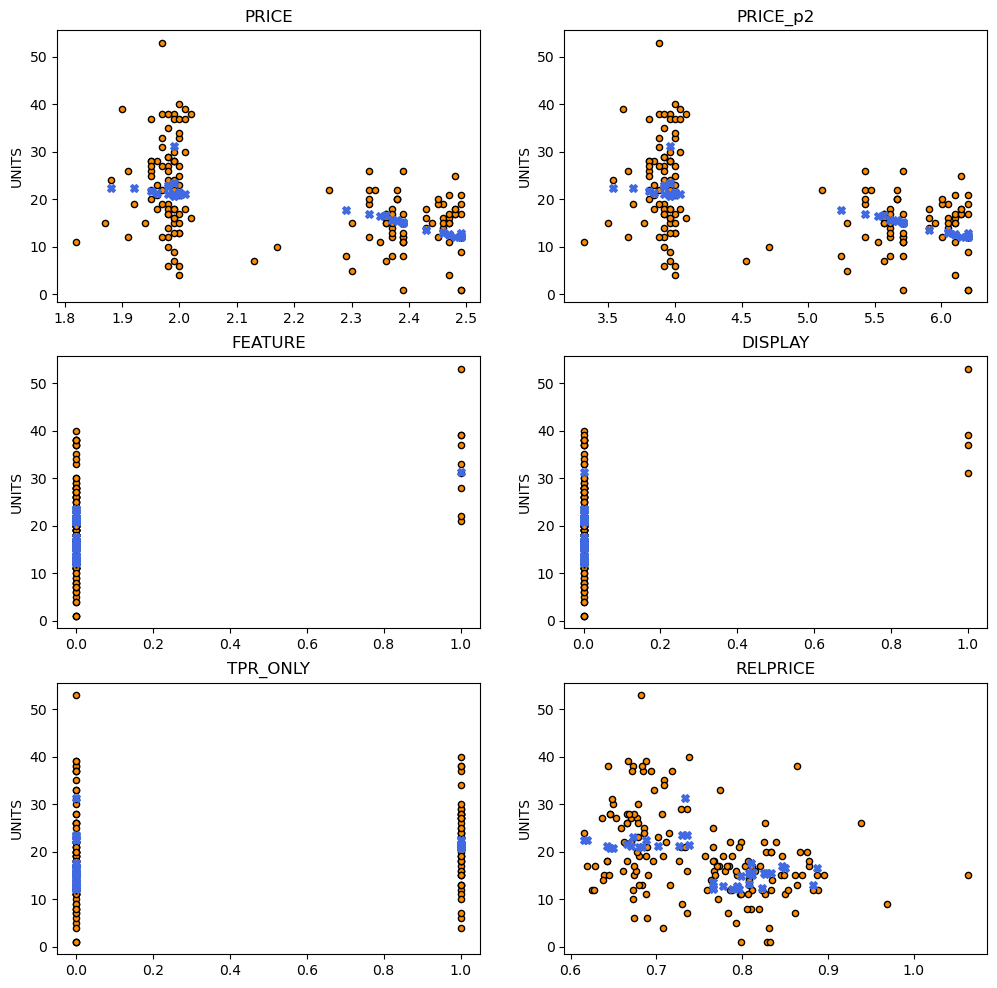

In [7]:
# Plot prediction results for a product (UPC)
upc = productList[1]
data_y = salesCereals.loc[salesCereals['UPC']==upc]['UNITS'].values
data_x = salesCereals.loc[salesCereals['UPC']==upc][feature_list].values
plot_data_scatter(data_x, data_y, X_test[upc], y_pred[upc], feature_list)

In order to see the impact of the price on the demand, we use a simple plot function below from mathplotlib to see how the demand would change when the price changes.

For more details of the plot function, please see: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html

D:\ProgramData\Anaconda3\envs\sca_book2\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


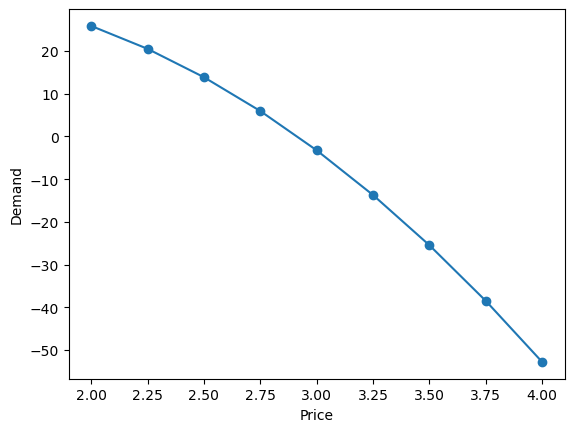

In [8]:
upc = productList[1]
input_x = []
prices = [2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]

# generate inputs for the plot using simple feature values and varying price points
for p in prices:
  input_x.append([p, p**2, 0,0,0, 1.0])

# obtain the predicted demands
predict_y = regr[upc].predict(input_x)
plt.plot(prices, predict_y, marker='o')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.show()

Likewise, we obtain the tree regression results by simply changing the function name and the result table name.

In [9]:
#Tree models
regr = {}
regrSummary = pandas.DataFrame(columns=['trainRMSE', 'testRMSE','testMAE','testMAPE'], index = productList)

for upc in productList:

    regr[upc] = sklearn.tree.DecisionTreeRegressor(random_state = 0).fit(X_train[upc],y_train[upc]) # standard regression tree
    # regr[upc] = sklearn.ensemble.RandomForestRegressor(random_state = 0).fit(X_train[upc],y_train[upc]) # random forest tree
    trainRMSE = numpy.sqrt(sklearn.metrics.mean_squared_error(y_train[upc], regr[upc].predict(X_train[upc])))
    y_pred[upc] = regr[upc].predict(X_test[upc])

    testMAE = sklearn.metrics.mean_absolute_error(y_test[upc], y_pred[upc])
    testMAPE = numpy.mean(numpy.abs((y_test[upc] - y_pred[upc]) / y_test[upc]))
    testRMSE = numpy.sqrt(sklearn.metrics.mean_squared_error(y_test[upc], y_pred[upc]))
    regrSummary.loc[upc] =  [trainRMSE, testRMSE, testMAE, testMAPE]

print('Regression Tree Summary')
print(regrSummary)
print('average training RMSE:' + str(round(regrSummary['trainRMSE'].mean(),2)))
print('average testing RMSE:' + str(round(regrSummary['testRMSE'].mean(),2)))
print('average testing MAE:' + str(round(regrSummary['testMAE'].mean(),2)))
print('average testing MAPE:' + str(round(regrSummary['testMAPE'].mean(),2)))


Regression Tree Summary
           trainRMSE   testRMSE    testMAE  testMAPE
1111085319  2.038099  10.759611   7.102564  0.841491
1111085350       0.0   7.471313   5.923077  0.625815
1600027527  1.147275  30.330234  15.564103  0.520292
1600027528   2.65623  13.221001   8.641026  0.286716
1600027564       0.0  10.453806   7.897436   0.38854
3000006340  0.514111   7.762087        4.5  0.992923
3800031829  1.543898   9.131518   7.487179  0.421318
average training RMSE:1.13
average testing RMSE:12.73
average testing MAE:8.16
average testing MAPE:0.58


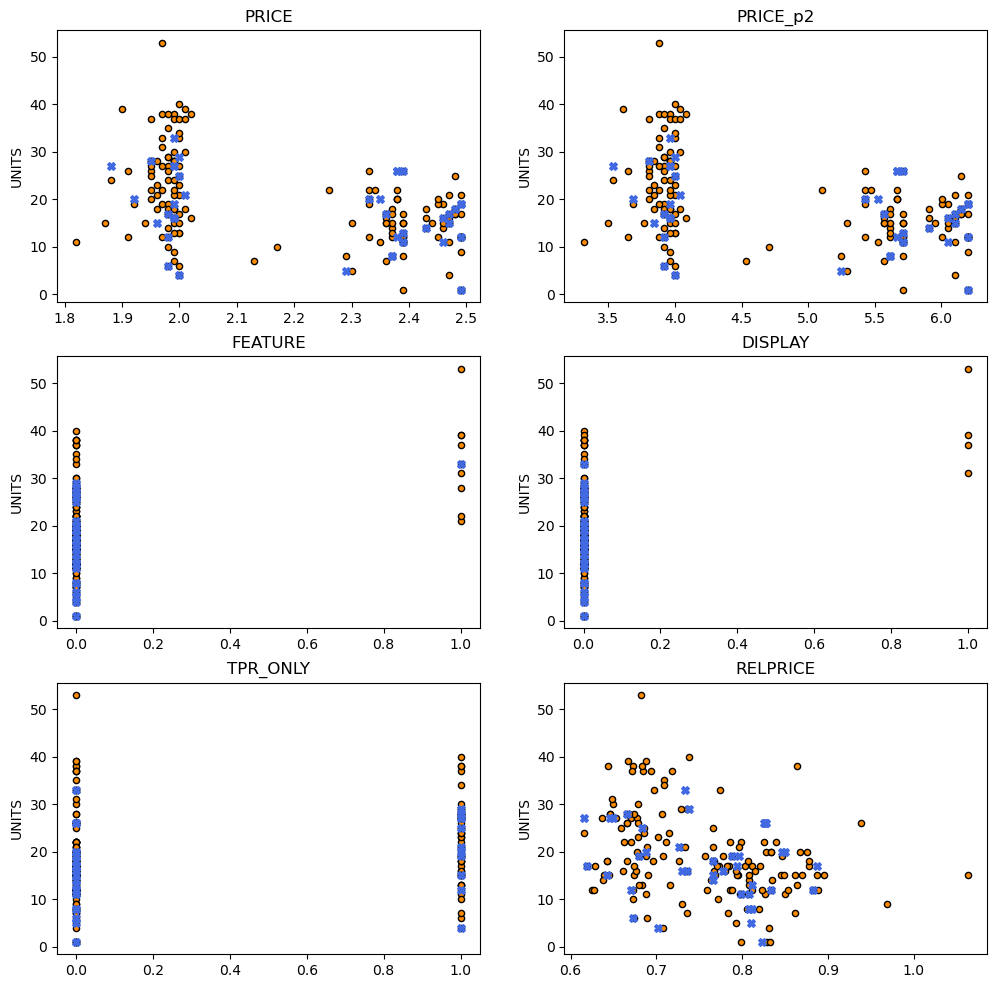

In [10]:
# Plot prediction results for a product (UPC)
upc = productList[1]
data_y = salesCereals.loc[salesCereals['UPC']==upc]['UNITS'].values
data_x = salesCereals.loc[salesCereals['UPC']==upc][feature_list].values
plot_data_scatter(data_x, data_y, X_test[upc], y_pred[upc], feature_list)

D:\ProgramData\Anaconda3\envs\sca_book2\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


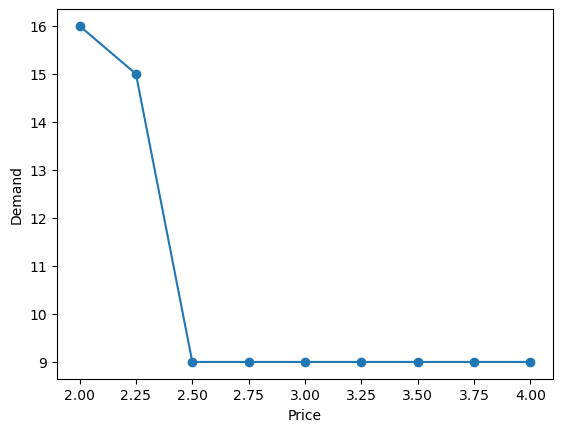

In [11]:
upc = productList[1]
input_x = []
prices = [2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]

# generate inputs for the plot using simple feature values and varying price points
for p in prices:
  input_x.append([p, p**2, 0,0,0, 1.0])

# obtain the predicted demands
predict_y = regr[upc].predict(input_x)
plt.plot(prices, predict_y, marker='o')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.show()

### Block 4: Model selection

By comparing the average result, we can see that the linear regression model generally outperformed the decision tree regression and did not overfit the data. Therefore, we proceed with the linear regression model for the whole dataset by replacing 'X_train' with 'X'. Given that the model has 'seen' the whole dataset, its forecast errors normally decrease. Therefore, we will save the trained model and use it for the new data which will be used in the optimization models in the next session.

In [12]:
# Best model
regr = {}
regrSummary = pandas.DataFrame(columns=['totalMAE','totalMAPE', 'totalRMSE'], index = productList)

for upc in productList:
    regr[upc] = sklearn.linear_model.LinearRegression().fit(X[upc],y[upc])
    y_pred[upc] = regr[upc].predict(X[upc])
    testMAE = sklearn.metrics.mean_absolute_error(y[upc], y_pred[upc])
    testMAPE = numpy.mean(numpy.abs((y[upc] - y_pred[upc]) / y[upc]))
    testRMSE = numpy.sqrt(sklearn.metrics.mean_squared_error(y[upc], y_pred[upc]))
    regrSummary.loc[upc] =  [testMAE, testMAPE, testRMSE]

print('Best Model Summary')
print(regrSummary)
print('average overall MAE:' + str(round(regrSummary['totalMAE'].mean(),2)))
print('average overall MAPE:' + str(round(regrSummary['totalMAPE'].mean(),2)))
print('average overall RMSE:' + str(round(regrSummary['totalRMSE'].mean(),2)))

Best Model Summary
            totalMAE totalMAPE  totalRMSE
1111085319  6.081658  0.643456   7.756732
1111085350  5.804481      0.64   7.312385
1600027527  9.773413  0.611309  16.926391
1600027528   7.05949  0.302731  10.426074
1600027564  5.990113  0.296792   8.303061
3000006340  2.865248  0.699564   4.119918
3800031829  6.164282  0.336052   7.810234
average overall MAE:6.25
average overall MAPE:0.5
average overall RMSE:8.95


### Save trained models

If you use Jupyter, you can save it to a local folder. The code below will put it in the current folder.

In [13]:
cwd = './'


Now we can save the files to the folder indicated by using the code below.

In [14]:
import pickle
# save the models to the drive
for upc in productList:
    filename = cwd+str(upc)+'_demand_model.sav'
    # save the model to disk
    pickle.dump(regr[upc], open(filename, 'wb'))